UNET for Multi-class Segmentation of Brain Tumors (meningioma, glioma, pituitary tumor)

NOTE: Restart the Python kernel between runs to clear the state

Pip Install all Packages via Terminal in the Correct activated VENV
OR !pip install package below if Jupyter

VENV for local installs: source SPR24ENV/bin/activate 
VENV for cluster installs: source UNETvenv/bin/activate 

In [25]:
import os
import sys
import numpy as np
import pandas as pd
import cv2  # opencv+python == 4.9.0.80 # image processing
import matplotlib.pyplot as plt
import hdf5storage  # 0.1.19 # for loading .mat files

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf # Ensure using 2.13.0 as mentioned
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import (Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Conv2DTranspose, BatchNormalization, Activation)
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers.legacy import Adam # trying legacy Adam for better performance
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator # optional data augmentation

import seaborn as sns
from collections import Counter

Ensure GPU is Connected for Local & Cluster Runs

In [26]:
# local check
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available; TensorFlow is using CPU")

# cluster check

GPU is available


Data Loading

In [27]:
path = '/Users/elizabethnemeti/Desktop/' # local runs
data_dir = os.path.join(path, 'data') # local runs
# data_dir = '/' # cluster runs

if not os.path.isdir(data_dir):
    raise FileNotFoundError(f"No such directory: {data_dir}") # debug check

files = os.listdir(data_dir)
print(f"Files in {data_dir}:", files) # should see 2124 mat files from Cheng 2016 dataset

Files in /Users/elizabethnemeti/Desktop/data: ['57_axial.mat', '1150_coronal.mat', '279_coronal.mat', '886_sagittal.mat', '472_sagittal.mat', '2093_axial.mat', '2773_sagittal.mat', '977_axial.mat', '402_coronal.mat', '146_axial.mat', '2611_coronal.mat', '1868_axial.mat', '1691_sagittal.mat', '1562_coronal.mat', '1435_axial.mat', '284_coronal.mat', '550_sagittal.mat', '1470_coronal.mat', '1120_coronal.mat', '396_coronal.mat', '881_sagittal.mat', '475_sagittal.mat', '2166_axial.mat', '2253_coronal.mat', '2774_sagittal.mat', '2350_axial.mat', '1353_axial.mat', '2661_coronal.mat', '2331_coronal.mat', '1696_sagittal.mat', '1512_coronal.mat', '1669_sagittal.mat', '7_axial.mat', '557_sagittal.mat', '2428_coronal.mat', '502_sagittal.mat', '1023_axial.mat', '335_coronal.mat', '128_axial.mat', '2817_sagittal.mat', '1828_sagittal.mat', '695_sagittal.mat', '39_axial.mat', '1270_sagittal.mat', '1225_sagittal.mat', '257_coronal.mat', '2960_sagittal.mat', '2935_sagittal.mat', '345_coronal.mat', '1421

Low Quality MRI Manually Inspected and Removed
- available in folder Poor_Quality_Discarded_Images

Data Preprocessing Pipeline

Sample = Pixel
- every pixel is treated separately and hails from the original images

Input: 512 x 512 images

- each mask will be labeled according to the tumor type (each class is represented by different integer labels in the mask)
- labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively
- include one-hot encoding for masks to ensure each mask is transformed into a binary format suitable for multi-class segmentation using categorical crossentropy in training/model architecture

1. Normalize pixel values
2. Create label classes for the 3 tumors
3. Make sure data types match as float32 for images and masks

ACTION REQUIRED: Select Resolution 128, 256, 512 pixels

Total files found: 2034
[2030/2034] images loaded: 99.8 %
Finished loading and processing data. Successfully processed 2034/2034 files.


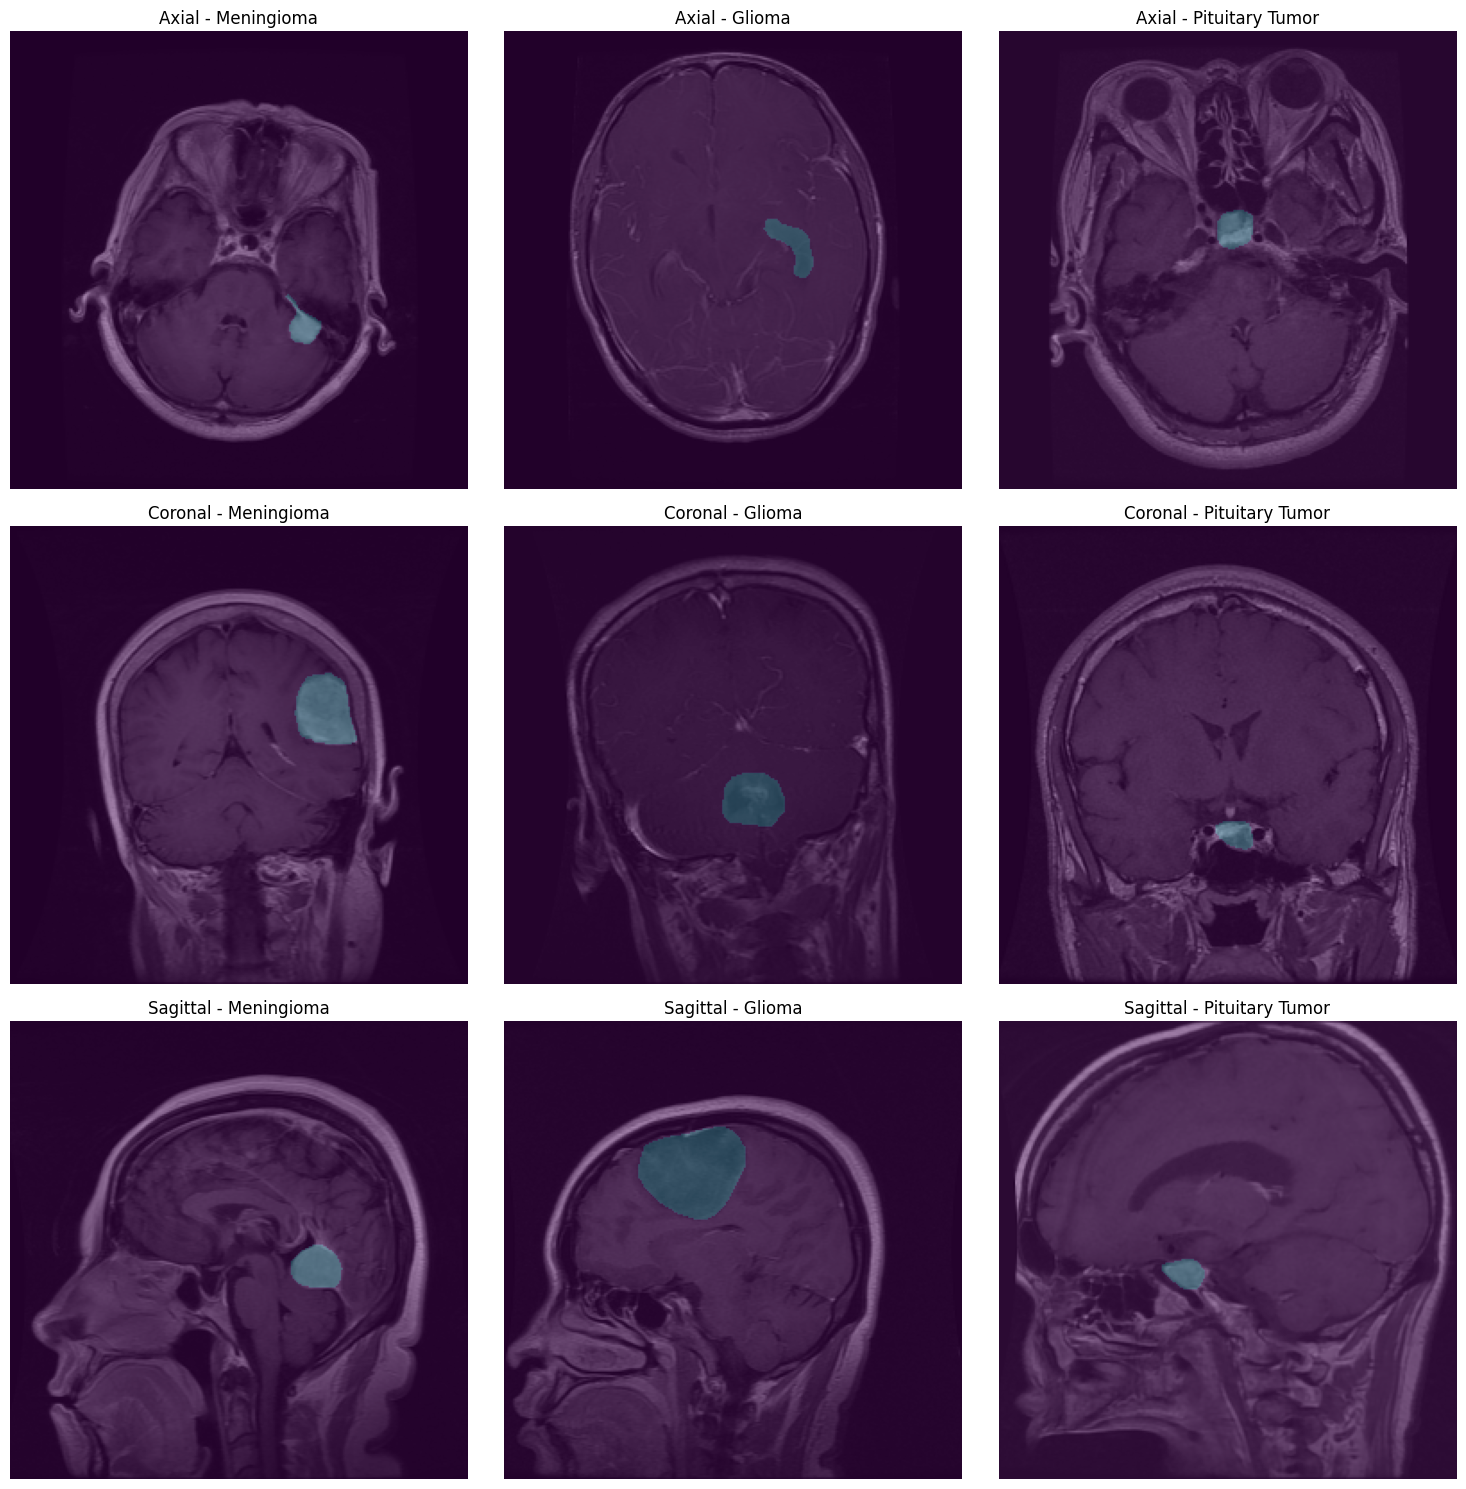

Label 1 (Meningioma): 670 slices, 32.94% of the dataset
Label 3 (Pituitary Tumor): 707 slices, 34.76% of the dataset
Label 2 (Glioma): 657 slices, 32.30% of the dataset
Data type of image: float32
Data type of masks: float32


In [28]:
def load_and_preprocess_data(data_dir, image_dimension=256):
    images = []
    masks = []
    labels = []
    planes = []
    files = [f for f in os.listdir(data_dir) if f != '.DS_Store'] # ignore any .DS_Store files on MacOS

    # Data integrity check
    print(f"Total files found: {len(files)}")
    processed_count = 0

    for i, file in enumerate(files, start=1):
        try:
            mat_file = hdf5storage.loadmat(os.path.join(data_dir, file))['cjdata'][0] # Load the .mat file

            # Resize and normalize the images
            image = mat_file['image']
            image = cv2.resize(image, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_CUBIC)
            image = image.astype(np.float32) / 255.0  # Scale image to range [0, 1]
            image = np.expand_dims(image, axis=-1)

            # Resize and prepare mask for multi-class segmentation
            mask = mat_file['tumorMask'].astype('uint8')
            mask = cv2.resize(mask, dsize=(image_dimension, image_dimension), interpolation=cv2.INTER_NEAREST)
            mask = np.expand_dims(mask, axis=-1) # add the channel dimension (prep for check later)

            # Get the label and convert to one-hot
            label = int(mat_file['label'])
            plane = identify_plane(file)  # identify the plane from the file name
            
            one_hot_mask = np.zeros((image_dimension, image_dimension, 3), dtype=np.float32)  # three classes # set dtype to float32
            for j in range(1, 4):  # labels are 1, 2, 3
                one_hot_mask[:, :, j-1] = (mask[:, :, 0] == j).astype(np.float32)  # Cast to float32

            images.append(image)
            masks.append(one_hot_mask)
            labels.append(label)
            planes.append(plane)
            processed_count += 1

            if i % 10 == 0:
                sys.stdout.write(f'\r[{i}/{len(files)}] images loaded: {i / float(len(files)) * 100:.1f} %')
                sys.stdout.flush()

        except Exception as e:
            print(f"Failed to process file {file}: {e}")

    print(f"\nFinished loading and processing data. Successfully processed {processed_count}/{len(files)} files.")
    return np.array(images), np.array(masks), np.array(labels), np.array(planes)

def identify_plane(file_name):
    if 'axial' in file_name.lower():
        return 'axial'
    elif 'coronal' in file_name.lower():
        return 'coronal'
    elif 'sagittal' in file_name.lower():
        return 'sagittal'
    else:
        return file_name  # debug check: return the file name if the plane type is unknown

def visualize_sample_images(images, masks, labels, planes):
    label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    plane_order = ['axial', 'coronal', 'sagittal']
    tumor_order = [1, 2, 3]

    samples = {plane: {label: None for label in tumor_order} for plane in plane_order}

    for idx, label in enumerate(labels):
        plane = planes[idx]
        if samples[plane][label] is None:
            samples[plane][label] = (images[idx], masks[idx], label)
        if all(all(samples[plane][label] is not None for label in tumor_order) for plane in plane_order):
            break

    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for row, plane in enumerate(plane_order):
        for col, label in enumerate(tumor_order):
            if samples[plane][label]:
                image, mask, label = samples[plane][label]
                tumor_type = label_to_tumor[label]
                title = f"{plane.capitalize()} - {tumor_type}"

                combined_mask = np.zeros_like(mask[..., 0])
                for i in range(mask.shape[-1]):
                    combined_mask += (mask[..., i] * (i + 1)).astype(np.uint8)

                ax = axes[row, col]
                ax.imshow(image.squeeze(), cmap='gray')
                ax.imshow(combined_mask, cmap='viridis', vmin=0, vmax=3, alpha=0.5)
                ax.set_title(title)
                ax.axis('off')

    plt.tight_layout()
    plt.show()

# debug check (recommended)
def check_data_distribution(labels):
    label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
    label_counts = Counter(labels)
    total_counts = len(labels)
    for label, count in label_counts.items():
        tumor_type = label_to_tumor.get(label, "Unknown Tumor Type")
        print(f"Label {label} ({tumor_type}): {count} slices, {count / total_counts * 100:.2f}% of the dataset")

data_dir = '/Users/elizabethnemeti/Desktop/data'
image_dimension = 256 # change if needed

images, masks, labels, planes = load_and_preprocess_data(data_dir, image_dimension)

visualize_sample_images(images, masks, labels, planes)

check_data_distribution(labels)

# debug check
print(f"Data type of image: {images.dtype}")
print(f"Data type of masks: {masks.dtype}")

ACTION REQUIRED BEFORE RUNNING: Select Tumor Type and/or Plane Type

In [43]:
def filter_data(images, masks, labels, planes, file_names, tumor_type='all', plane_type='all'):
    """Filter the dataset based on the selected tumor type and plane type."""
    
    # Check for valid tumor type and plane type
    if tumor_type not in ['all', 'meningioma', 'glioma', 'pituitary']:
        raise ValueError("Invalid tumor type. Choose from 'all', 'meningioma', 'glioma', 'pituitary'.")
    
    if plane_type not in ['all', 'axial', 'coronal', 'sagittal']:
        raise ValueError("Invalid plane type. Choose from 'all', 'axial', 'coronal', 'sagittal'.")
    
    # Filter by tumor type
    if tumor_type != 'all':
        tumor_type_to_label = {'meningioma': 1, 'glioma': 2, 'pituitary': 3}
        selected_label = tumor_type_to_label[tumor_type]
        tumor_filtered_indices = [i for i, lbl in enumerate(labels) if lbl == selected_label]
    else:
        tumor_filtered_indices = range(len(labels))
    
    # Filter by plane type
    if plane_type != 'all':
        plane_filtered_indices = [i for i in tumor_filtered_indices if planes[i] == plane_type]
    else:
        plane_filtered_indices = tumor_filtered_indices
    
    filtered_file_names = [file_names[i] for i in plane_filtered_indices]
    filtered_labels = [labels[i] for i in plane_filtered_indices]
    filtered_planes = [planes[i] for i in plane_filtered_indices]

    return filtered_file_names, filtered_labels, filtered_planes


### ACTION REQUIRED ###
tumor_type = 'glioma'  # change to 'all', 'meningioma', 'glioma', or 'pituitary'
plane_type = 'sagittal'  # change to 'all', 'axial', 'coronal', or 'sagittal'

images, masks, labels, planes = load_and_preprocess_data(data_dir, image_dimension)

file_names = [f for f in os.listdir(data_dir) if f != '.DS_Store'] # ignore .DS store agian on Macs

filtered_file_names, filtered_labels, filtered_planes = filter_data(images, masks, labels, planes, file_names, tumor_type, plane_type)

# debug check: does plane selection match file name?
label_to_tumor = {1: 'Meningioma', 2: 'Glioma', 3: 'Pituitary Tumor'}
for file_name, label, plane in zip(filtered_file_names, filtered_labels, filtered_planes):
    print(f"File: {file_name}, Label: {label_to_tumor[label]}, Plane: {plane}")

check_data_distribution(filtered_labels)

Total files found: 2034
[2030/2034] images loaded: 99.8 %
Finished loading and processing data. Successfully processed 2034/2034 files.
File: 886_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2773_sagittal.mat, Label: Glioma, Plane: sagittal
File: 881_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2774_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2817_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2960_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2935_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2845_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2998_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2967_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2932_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2761_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2766_sagittal.mat, Label: Glioma, Plane: sagittal
File: 2799_sagittal.mat, Label: Glioma, Plane: sagittal
File: 893_sagittal.mat, Label: Glioma, Plane: sagittal
File: 839_sagittal.mat, Lab

Check Dimensions Before Training (optional, recommended)

- MRI scans are generally single-channel (grayscale), where each pixel represents an intensity value.
- Lack of an explicit channel dimension in the arrays ((512, 512) instead of (512, 512, 1)) is common because the single channel is implicit in grayscale images.
- However, for processing in DL models like U-Net, we need to explicitly include the channel dimension.

- FOR IMAGES: typically single-channel for grayscale -> correct shape is (512, 512, 1) for DL processing
- FOR MASKS: for multi-class segmentation, especially when one-hot encoded with three classes (Meningioma, Glioma, Pituitary Tumor), should have shape (512, 512, 3) where each channel corresponds to one class

In [30]:
def check_dimensions(images, masks, required_image_shape, required_mask_shape):
    assert images[0].shape == required_image_shape, f"Image shape mismatch: expected {required_image_shape}, got {images[0].shape}"
    assert masks[0].shape == required_mask_shape, f"Mask shape mismatch: expected {required_mask_shape}, got {masks[0].shape}"
    print(f"Image shape is {images[0].shape} and mask shape is {masks[0].shape}.")
    print("All images and masks correctly match the required shapes.")

# Required shape for U-Net
required_image_shape = (256, 256, 1)  # for the images -> grayscale and should have a single channel explicitly
required_mask_shape = (256, 256, 3)   # for the masks -> which are one-hot encoded across three classes

check_dimensions(images, masks, required_image_shape, required_mask_shape)

Image shape is (256, 256, 1) and mask shape is (256, 256, 3).
All images and masks correctly match the required shapes.


Local Save (optional)

save_path = '/' # local runs
# save_path = '/' # cluster runs

np.save(os.path.join(save_path, 'images.npy'), images)
np.save(os.path.join(save_path, 'masks.npy'), masks)
np.save(os.path.join(save_path, 'labels.npy'), labels)

Splitting the dataset into Training, Validation and Test Set

- Split Training, Validation and Testing data
- 80% (60:20) training + validation -> data for learning and to tune the model's hyperparameters without overfitting
- 20% testing -> to evaluate model's performance on unseen data
- Using Single validation split strategy for less computation time/resources
- use 5-fold cross validation if computational resources allow

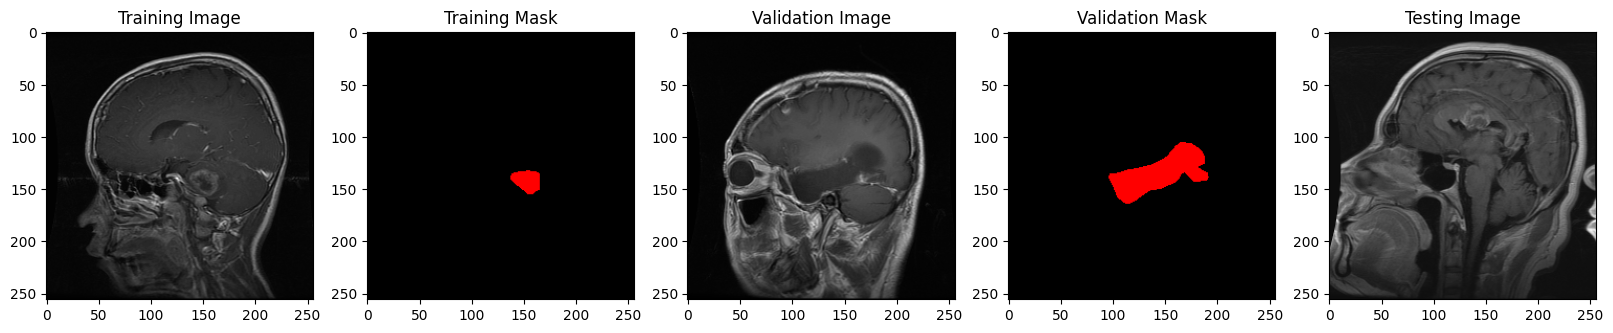

Filtered Label Distribution: {2: 182}
Training Label Distribution: {2: 108}
Validation Label Distribution: {2: 37}
Testing Label Distribution: {2: 37}
Data type of images_train: float32
Data type of masks_train: float32
Data type of labels_train: int64
Data type of images_val: float32
Data type of masks_val: float32
Data type of labels_val: int64
Data type of images_test: float32
Data type of masks_test: float32
Data type of labels_test: int64
Training Images shape: (108, 256, 256, 1)
Training Masks shape: (108, 256, 256, 3)
Validation Images shape: (37, 256, 256, 1)
Validation Masks shape: (37, 256, 256, 3)
Testing Images shape: (37, 256, 256, 1)
Testing Masks shape: (37, 256, 256, 3)


In [44]:
def split_data(images, masks, labels, test_size=0.2, val_size=0.2, random_state=42):
    """
    Split data into training, validation, and testing sets.
    - test_size specifies the proportion of the data for testing.
    - val_size specifies the proportion of the training data for validation.
    """
    images_train, images_test, masks_train, masks_test, labels_train, labels_test = train_test_split(
        images, masks, labels, test_size=test_size, random_state=random_state, stratify=labels)
    
    images_train, images_val, masks_train, masks_val, labels_train, labels_val = train_test_split(
        images_train, masks_train, labels_train, test_size=val_size, random_state=random_state, stratify=labels_train)

    return images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test

def check_distribution(labels, title="Label distribution"):
    """Print the distribution of labels."""
    unique, counts = np.unique(labels, return_counts=True)
    label_dict = dict(zip(unique, counts))
    print(f"{title}: {label_dict}")

def visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test):
    """Display the first image and mask from training, validation, and testing sets."""
    fig, axes = plt.subplots(1, 5, figsize=(20, 4))
    axes[0].imshow(images_train[0], cmap='gray')
    axes[0].set_title('Training Image')
    axes[1].imshow(masks_train[0], cmap='viridis')
    axes[1].set_title('Training Mask')
    axes[2].imshow(images_val[0], cmap='gray')
    axes[2].set_title('Validation Image')
    axes[3].imshow(masks_val[0], cmap='viridis')
    axes[3].set_title('Validation Mask')
    axes[4].imshow(images_test[0], cmap='gray')
    axes[4].set_title('Testing Image')
    plt.show()

# Split the filtered data into training, validation, and testing sets
images_train, masks_train, labels_train, images_val, masks_val, labels_val, images_test, masks_test, labels_test = split_data(
    filtered_images, filtered_masks, filtered_labels, test_size=0.2, val_size=0.25)

# Visualization for the first training, validation, and testing images
visualize_data_samples(images_train, masks_train, images_val, masks_val, images_test)

# Check label distributions
check_distribution(filtered_labels, "Filtered Label Distribution")
check_distribution(labels_train, "Training Label Distribution")
check_distribution(labels_val, "Validation Label Distribution")
check_distribution(labels_test, "Testing Label Distribution")

# DEBUG: Check data types to make sure images and masks are float32, all labels can be int64
print(f"Data type of images_train: {np.array(images_train).dtype}")
print(f"Data type of masks_train: {np.array(masks_train).dtype}")
print(f"Data type of labels_train: {np.array(labels_train).dtype}")
print(f"Data type of images_val: {np.array(images_val).dtype}")
print(f"Data type of masks_val: {np.array(masks_val).dtype}")
print(f"Data type of labels_val: {np.array(labels_val).dtype}")
print(f"Data type of images_test: {np.array(images_test).dtype}")
print(f"Data type of masks_test: {np.array(masks_test).dtype}")
print(f"Data type of labels_test: {np.array(labels_test).dtype}")

print(f"Training Images shape: {np.array(images_train).shape}")
print(f"Training Masks shape: {np.array(masks_train).shape}")

print(f"Validation Images shape: {np.array(images_val).shape}")
print(f"Validation Masks shape: {np.array(masks_val).shape}")

print(f"Testing Images shape: {np.array(images_test).shape}")
print(f"Testing Masks shape: {np.array(masks_test).shape}")

data_sets = {
    'training': (images_train, masks_train),
    'validation': (images_val, masks_val),
    'testing': (images_test, masks_test)
}

Defining Metrics Stage

True Masks:
Shape: (batch_size, height, width, num_classes)

Predicted Masks:
Shape: (batch_size, height, width, num_classes)

(OPTIONAL) DEBUG CHECK: Verify the Metrics Calculatate as Expected inside Metrics.ipynb notebook) 

Dice Coefficient (dice_coef):
- Calculates Dice coefficients for each class.
- Returns both individual class scores and the mean Dice coefficient.

Intersection over Union (iou_coef):
- Calculates IoU coefficients for each class.
- Returns both individual class scores and the mean IoU coefficient.

Dice Loss (dice_loss):
- Calculates Dice loss for a single class from one-hot encoded masks.

Combined Loss (calculate_losses):
- Calculates the combined loss (categorical cross-entropy and Dice) per class and the mean loss.
- Uses user-defined weights for both loss terms.

Multi-Class Accuracy (calculate_accuracies):
- Calculates accuracy metrics for each class and the mean accuracy across all classes.

Regular Dice and Jaccard Metrics

- Dice coeffiecient -> calculates the overlap between the predicted and true masks in segmentation (0-1 score)
- IoU (jaccard) coeffiecient -> measures similarity/diversity between predicted and true masks (0-1 score)
- as coefficients we want to maximize them (the closer to 1 the better) 

note: 
- the loss is a training tool, not a direct measure of segmentation quality therefore we use the coefficients to do so
- coefficients are not influenced by combined loss function

In [32]:
def mean_dice_coef(true_mask, pred_mask, smooth=1.0, num_classes=3):
    dice_scores = []
    for class_idx in range(num_classes):
        class_true_mask = true_mask[..., class_idx]
        class_pred_mask = pred_mask[..., class_idx]
        intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
        sum_true_mask = tf.reduce_sum(class_true_mask)
        sum_pred_mask = tf.reduce_sum(class_pred_mask)
        dice_score = (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
        dice_scores.append(dice_score)
    mean_dice = tf.reduce_mean(dice_scores)
    return mean_dice

def dice_coef_class_0(true_mask, pred_mask, smooth=1.0):
    class_true_mask = true_mask[..., 0]
    class_pred_mask = pred_mask[..., 0]
    intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
    sum_true_mask = tf.reduce_sum(class_true_mask)
    sum_pred_mask = tf.reduce_sum(class_pred_mask)
    dice_score = (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
    return dice_score

def dice_coef_class_1(true_mask, pred_mask, smooth=1.0):
    class_true_mask = true_mask[..., 1]
    class_pred_mask = pred_mask[..., 1]
    intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
    sum_true_mask = tf.reduce_sum(class_true_mask)
    sum_pred_mask = tf.reduce_sum(class_pred_mask)
    dice_score = (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
    return dice_score

def dice_coef_class_2(true_mask, pred_mask, smooth=1.0):
    class_true_mask = true_mask[..., 2]
    class_pred_mask = pred_mask[..., 2]
    intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
    sum_true_mask = tf.reduce_sum(class_true_mask)
    sum_pred_mask = tf.reduce_sum(class_pred_mask)
    dice_score = (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
    return dice_score

In [33]:
def mean_iou_coef(true_mask, pred_mask, smooth=1.0, num_classes=3):
    iou_scores = []
    for class_idx in range(num_classes):
        class_true_mask = true_mask[..., class_idx]
        class_pred_mask = pred_mask[..., class_idx]
        intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
        sum_true_mask = tf.reduce_sum(class_true_mask)
        sum_pred_mask = tf.reduce_sum(class_pred_mask)
        union = sum_true_mask + sum_pred_mask - intersection
        iou_score = (intersection + smooth) / (union + smooth)
        iou_scores.append(iou_score)
    mean_iou = tf.reduce_mean(iou_scores)
    return mean_iou

def iou_coef_class_0(true_mask, pred_mask, smooth=1.0):
    class_true_mask = true_mask[..., 0]
    class_pred_mask = pred_mask[..., 0]
    intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
    sum_true_mask = tf.reduce_sum(class_true_mask)
    sum_pred_mask = tf.reduce_sum(class_pred_mask)
    union = sum_true_mask + sum_pred_mask - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def iou_coef_class_1(true_mask, pred_mask, smooth=1.0):
    class_true_mask = true_mask[..., 1]
    class_pred_mask = pred_mask[..., 1]
    intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
    sum_true_mask = tf.reduce_sum(class_true_mask)
    sum_pred_mask = tf.reduce_sum(class_pred_mask)
    union = sum_true_mask + sum_pred_mask - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

def iou_coef_class_2(true_mask, pred_mask, smooth=1.0):
    class_true_mask = true_mask[..., 2]
    class_pred_mask = pred_mask[..., 2]
    intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
    sum_true_mask = tf.reduce_sum(class_true_mask)
    sum_pred_mask = tf.reduce_sum(class_pred_mask)
    union = sum_true_mask + sum_pred_mask - intersection
    iou_score = (intersection + smooth) / (union + smooth)
    return iou_score

Custom Combined Loss Func

- primary training loss function
- we want to minimize the loss (closer to 0 the better)
- categorical crossentropy + dice loss
- Dice loss -> minimizes difference between the predicted and true masks
- adjust the weighting/scales between categorical crossentropy and Dice loss to improve performance

Use only this loss function (mean loss not individual) in the model compilation/training

- in order to integrate with Keras (compatibility) need to return a single value for the loss during training only
- save individual loss calc for evaluation

In [34]:
def dice_loss(true_mask, pred_mask, smooth=1.0):
    intersection = tf.reduce_sum(true_mask * pred_mask)
    sum_true_mask = tf.reduce_sum(true_mask)
    sum_pred_mask = tf.reduce_sum(pred_mask)
    dice_loss_value = 1 - (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
    return dice_loss_value

def combined_loss_class_0(true_mask, pred_mask, weight_ce=0.1, weight_dice=0.9):
    true_class = true_mask[..., 0]
    pred_class = pred_mask[..., 0]
    ce_loss = tf.keras.losses.categorical_crossentropy(true_class, pred_class)
    dice_loss_value = dice_loss(true_class, pred_class)
    combined_loss_value = weight_ce * ce_loss + weight_dice * dice_loss_value
    class_loss = tf.reduce_mean(combined_loss_value)
    return class_loss

def combined_loss_class_1(true_mask, pred_mask, weight_ce=0.1, weight_dice=0.9):
    true_class = true_mask[..., 1]
    pred_class = pred_mask[..., 1]
    ce_loss = tf.keras.losses.categorical_crossentropy(true_class, pred_class)
    dice_loss_value = dice_loss(true_class, pred_class)
    combined_loss_value = weight_ce * ce_loss + weight_dice * dice_loss_value
    class_loss = tf.reduce_mean(combined_loss_value)
    return class_loss

def combined_loss_class_2(true_mask, pred_mask, weight_ce=0.1, weight_dice=0.9):
    true_class = true_mask[..., 2]
    pred_class = pred_mask[..., 2]
    ce_loss = tf.keras.losses.categorical_crossentropy(true_class, pred_class)
    dice_loss_value = dice_loss(true_class, pred_class)
    combined_loss_value = weight_ce * ce_loss + weight_dice * dice_loss_value
    class_loss = tf.reduce_mean(combined_loss_value)
    return class_loss

def mean_combined_loss(true_mask, pred_mask, weight_ce=0.1, weight_dice=0.9, num_classes=3):
    class_losses = []
    for i in range(num_classes):
        true_class = true_mask[..., i]
        pred_class = pred_mask[..., i]
        ce_loss = tf.keras.losses.categorical_crossentropy(true_class, pred_class)
        dice_loss_value = dice_loss(true_class, pred_class)
        combined_loss_value = weight_ce * ce_loss + weight_dice * dice_loss_value
        class_loss = tf.reduce_mean(combined_loss_value)
        class_losses.append(class_loss)
    mean_loss = tf.reduce_mean(tf.stack(class_losses), axis=0)
    return mean_loss

In [35]:
def mean_accuracy_metric(true_mask, pred_mask, num_classes=3):
    accuracies = []
    for i in range(num_classes):
        true_class = tf.equal(tf.argmax(true_mask, axis=-1), i)
        pred_class = tf.equal(tf.argmax(pred_mask, axis=-1), i)
        correct_predictions = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
        total_predictions = tf.reduce_sum(tf.cast(true_class, tf.float32))
        accuracy = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
        accuracies.append(accuracy)
    mean_accuracy = tf.reduce_mean(accuracies)
    return mean_accuracy

def accuracy_class_0(true_mask, pred_mask):
    true_class = tf.equal(tf.argmax(true_mask, axis=-1), 0)
    pred_class = tf.equal(tf.argmax(pred_mask, axis=-1), 0)
    correct_predictions = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
    total_predictions = tf.reduce_sum(tf.cast(true_class, tf.float32))
    accuracy = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
    return accuracy

def accuracy_class_1(true_mask, pred_mask):
    true_class = tf.equal(tf.argmax(true_mask, axis=-1), 1)
    pred_class = tf.equal(tf.argmax(pred_mask, axis=-1), 1)
    correct_predictions = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
    total_predictions = tf.reduce_sum(tf.cast(true_class, tf.float32))
    accuracy = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
    return accuracy

def accuracy_class_2(true_mask, pred_mask):
    true_class = tf.equal(tf.argmax(true_mask, axis=-1), 2)
    pred_class = tf.equal(tf.argmax(pred_mask, axis=-1), 2)
    correct_predictions = tf.reduce_sum(tf.cast(tf.logical_and(true_class, pred_class), tf.float32))
    total_predictions = tf.reduce_sum(tf.cast(true_class, tf.float32))
    accuracy = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
    return accuracy

Creating Metrics Collector for Training and Tracking

In [36]:
class MetricsCollector(tf.keras.callbacks.Callback):
    def __init__(self, validation_data, num_classes=3):
        super(MetricsCollector, self).__init__()
        self.validation_data = validation_data
        self.num_classes = num_classes
        self.metrics_history = []

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        val_images, true_mask = self.validation_data
        pred_mask = self.model.predict(val_images)

        pred_mask = tf.argmax(pred_mask, axis=-1)
        pred_mask = tf.one_hot(pred_mask, depth=self.num_classes)

        if true_mask.shape[-1] == 1:
            true_mask = tf.squeeze(true_mask, axis=-1)
            true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=self.num_classes)
        elif true_mask.shape[-1] != self.num_classes:
            true_mask = tf.one_hot(tf.cast(true_mask, tf.int32), depth=self.num_classes)

        true_mask = tf.convert_to_tensor(true_mask, dtype=tf.float32)
        pred_mask = tf.convert_to_tensor(pred_mask, dtype=tf.float32)

        # Calculate validation accuracy
        mean_acc, class_accs = self.calculate_accuracies(true_mask, pred_mask)
        logs['val_mean_accuracy_metric'] = mean_acc.numpy()
        for i in range(self.num_classes):
            logs[f'val_accuracy_class_{i}'] = class_accs[i].numpy()

        # Calculate validation loss
        mean_loss = mean_combined_loss(true_mask, pred_mask, self.num_classes)
        logs['val_mean_combined_loss'] = mean_loss.numpy()

        # Calculate validation Dice coefficient and IoU
        dice_scores, mean_dice = self.calculate_dice_coef(true_mask, pred_mask)
        iou_scores, mean_iou = self.calculate_iou_coef(true_mask, pred_mask)

        logs['val_mean_dice_coef'] = mean_dice.numpy()
        logs['val_mean_iou_coef'] = mean_iou.numpy()
        for i in range(self.num_classes):
            logs[f'val_dice_coef_class_{i}'] = dice_scores[i].numpy()
            logs[f'val_iou_coef_class_{i}'] = iou_scores[i].numpy()

        # calculate individual combined loss for validation
        for i in range(self.num_classes):
            class_loss = self.calculate_combined_loss(true_mask, pred_mask, i)
            logs[f'val_combined_loss_class_{i}'] = class_loss.numpy()

        self.metrics_history.append(logs)
        print(f"Epoch {epoch + 1} validation metrics collected.")

    def calculate_accuracies(self, true_mask, pred_mask):
        class_accs = []
        for i in range(self.num_classes):
            class_true_mask = true_mask[..., i]
            class_pred_mask = pred_mask[..., i]
            correct_predictions = tf.reduce_sum(tf.cast(class_true_mask * class_pred_mask, tf.float32))
            total_predictions = tf.reduce_sum(class_true_mask)
            class_acc = correct_predictions / (total_predictions + tf.keras.backend.epsilon())
            class_accs.append(class_acc)
        mean_acc = tf.reduce_mean(class_accs)
        return mean_acc, class_accs

    def calculate_dice_coef(self, true_mask, pred_mask, smooth=1.0):
        num_classes = true_mask.shape[-1]
        dice_scores = []
        for class_idx in range(num_classes):
            class_true_mask = true_mask[..., class_idx]
            class_pred_mask = pred_mask[..., class_idx]
            intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
            sum_true_mask = tf.reduce_sum(class_true_mask)
            sum_pred_mask = tf.reduce_sum(class_pred_mask)
            dice_score = (2. * intersection + smooth) / (sum_true_mask + sum_pred_mask + smooth)
            dice_scores.append(dice_score)
        mean_dice = tf.reduce_mean(dice_scores)
        return dice_scores, mean_dice

    def calculate_iou_coef(self, true_mask, pred_mask, smooth=1.0):
        num_classes = true_mask.shape[-1]
        iou_scores = []
        for class_idx in range(num_classes):
            class_true_mask = true_mask[..., class_idx]
            class_pred_mask = pred_mask[..., class_idx]
            intersection = tf.reduce_sum(class_true_mask * class_pred_mask)
            sum_true_mask = tf.reduce_sum(class_true_mask)
            sum_pred_mask = tf.reduce_sum(class_pred_mask)
            union = sum_true_mask + sum_pred_mask - intersection
            iou_score = (intersection + smooth) / (union + smooth)
            iou_scores.append(iou_score)
        mean_iou = tf.reduce_mean(iou_scores)
        return iou_scores, mean_iou

    def calculate_combined_loss(self, true_mask, pred_mask, class_idx, weight_ce=0.1, weight_dice=0.9):
        true_class = true_mask[..., class_idx]
        pred_class = pred_mask[..., class_idx]
        ce_loss = tf.keras.losses.categorical_crossentropy(true_class, pred_class)
        dice_loss_value = dice_loss(true_class, pred_class)
        combined_loss_value = weight_ce * ce_loss + weight_dice * dice_loss_value
        class_loss = tf.reduce_mean(combined_loss_value)
        return class_loss

    def on_train_end(self, logs=None):
        """
        Converts the historical metrics into a Pandas DataFrame and prints it for easy visualization.

        Args:
            logs: (Optional) Dictionary of logs accumulated during training (not used here).
        """
        import pandas as pd
        metrics_df = pd.DataFrame(self.metrics_history)
        print("Training Metrics per Epoch:")
        print(metrics_df.to_string(index=False))
        self.metrics_df = metrics_df


UNET Model Architecture

- defined the model's structure, how it should compile, including what optimizer, loss function, and metrics to use
- make suire images are scaled to [0, 1] to fit ReLU activation in the network
- Dropout prevents overfitting by randomly setting a fraction of input units to 0 at each update during training time
- Batch Normalization helps in accelerating the training process by normalizing the inputs of activation functions

Slow training?
- potentially change image sizd from 512 -> 256 for lower resolution but quicker training
- change learning rate
- fewer epochs/batches
- connect better GPU/more GPUs
- monitor fewer metrics

Setting Parameters

In [37]:
# set training parameters early 
num_samples = len(images_train)
#learning_rate = 1e-4 # e.g. 1e-5 for mini updates/slower convergence -> 1e-1 for big weight updates/faster convergence
initial_learning_rate = 1e-4
# epochs set here for both models
#epochs = 5
batch_size = 8
steps_per_epoch = num_samples // batch_size
seed = 30

In [38]:
def unet(weights=None, input_size=(256, 256, 1)):
    """
    Creates a U-Net model for image segmentation with 3 output classes.

    Args:
         weights: Path to pre-trained weights file (optional).
        input_size: Size of the input image (width, height, channels). Defaults to (256, 256, 1) for grayscale images.

    Returns:
        A compiled U-Net model for image segmentation.

    """

    inp = tf.keras.Input(input_size)

    # --------------------------
    # Encoder (Contracting Path)
    # --------------------------

    # Block 1: Two convolutional layers followed by pooling to downsample
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inp)
    c1 = BatchNormalization()(c1)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D(pool_size=(2, 2))(c1)

    # Block 2
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D(pool_size=(2, 2))(c2)
    p2 = Dropout(0.3)(p2)

    # Block 3
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D(pool_size=(2, 2))(c3)

    # Block 4
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    # Block 5: Bottleneck part, no pooling
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    c5 = BatchNormalization()(c5)

    # --------------------------
    # Decoder (Expanding Path)
    # --------------------------

    # Block 6: Upsample and concatenate with corresponding encoder layer
    u6 = Conv2DTranspose(512, (3, 3), strides=(2, 2), padding='same')(c5)
    concat6 = concatenate([u6, c4])
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(concat6)
    c6 = BatchNormalization()(c6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    c6 = BatchNormalization()(c6)

    # Block 7
    u7 = Conv2DTranspose(256, (3, 3), strides=(2, 2), padding='same')(c6)
    concat7 = concatenate([u7, c3])
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(concat7)
    c7 = BatchNormalization()(c7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    c7 = BatchNormalization()(c7)

    # Block 8: Upsample and concatenate with corresponding encoder layer
    u8 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(c7)
    concat8 = concatenate([u8, c2])
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat8)
    c8 = BatchNormalization()(c8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.3)(c8)  # Apply dropout for regularization

    # Block 9: Final upsampling and concatenation with the first encoder layer
    u9 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c8)
    concat9 = concatenate([u9, c1])
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat9)
    c9 = BatchNormalization()(c9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    c9 = BatchNormalization()(c9)

    # Output Layer
    outputs = Conv2D(3, (1, 1), activation='softmax')(c9)  # 3 classes for the 3 tumor types

    # model assembly
    model = Model(inputs=[inp], outputs=[outputs])

    # compile model with chosen optimizer, loss function, and metrics - use most custom metrics for evaluation only
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss=mean_combined_loss, 
        metrics=[
            mean_accuracy_metric, accuracy_class_0, accuracy_class_1, accuracy_class_2,
            mean_dice_coef, dice_coef_class_0, dice_coef_class_1, dice_coef_class_2,
            mean_iou_coef, iou_coef_class_0, iou_coef_class_1, iou_coef_class_2,
            mean_combined_loss, combined_loss_class_0, combined_loss_class_1, combined_loss_class_2
    ]
)

    return model

Data Augmentation Stage

- implemented next with model training (do NOT use on validation or testing data)
- doesn't actually create additional 'physical' images that are stores, makes 'virtual' variations real-time only used during that training
- data augmentation = randomly transforming images via shifts, flips, rotations, zooms for better generalizability performance
- do NOT merge the generators, they must stay separate to retain correct channel number = 1
- using ImageDataGenerator from Keras (note: just specifies/defines HOW to perform augmentations - doesn't generate data by itself)
- can adjust parameters as needed, but avoid aggressive transformations to refrain from introducing artifacts
- MUST select matching seeds to prevent misalignment between an augmented image and its corresponding augmented image
- quality of augmentions can be altered/improved by changing parameter 'fill_mode' that can be set to either:
      - default 'nearest' (replicates nearest pixel value)
      - 'constant' (pixels filled with a constant value, where 0 is black)
      - 'reflect' (pixels filled in mirrored fashion of the image border) 
      - 'wrap' (pixels filled from opposite image border than reflect does)

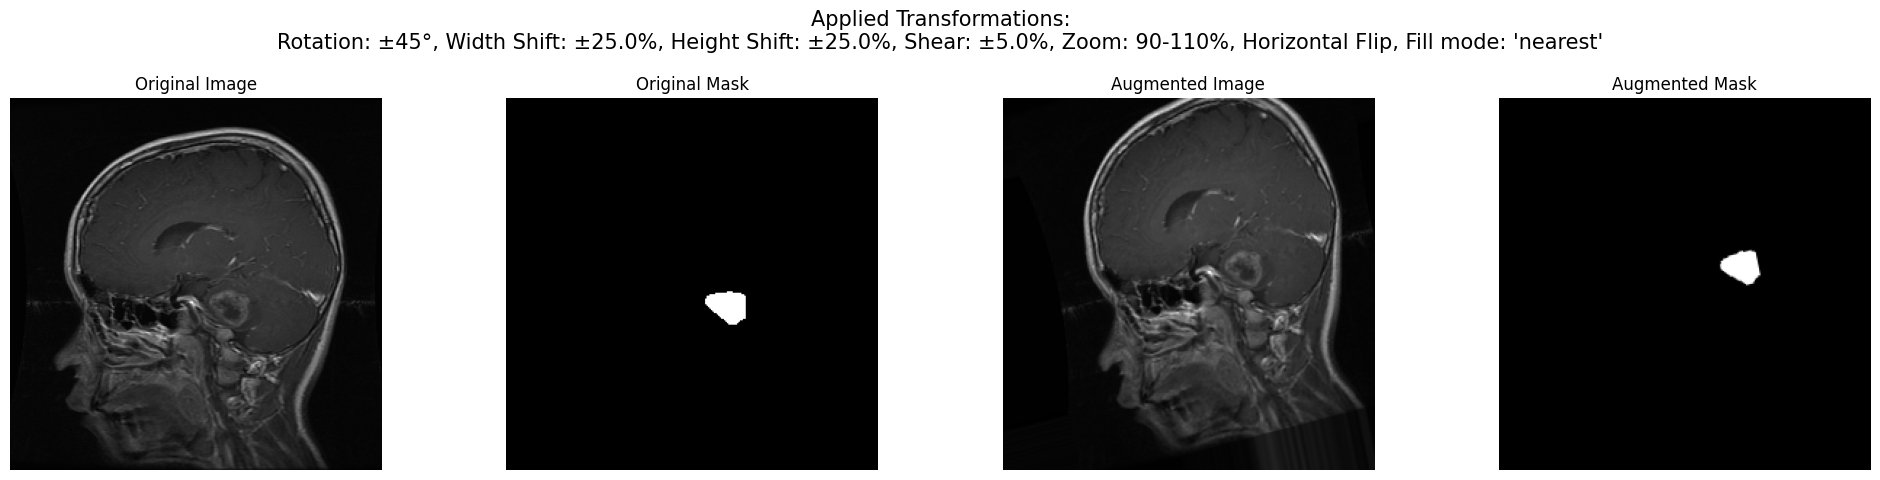

Checking first batch output:


AttributeError: 'list' object has no attribute 'shape'

In [41]:
# Data Augmentation (optional, recommended)
is_augmented = True # activate augmentation Y/N?

# func to indicate whether or not augmentation (and its params) should be applied via boolean 'augment'
def get_augmentation_params(is_augmented):
    if is_augmented:                    # will augment
        return {
            'rotation_range': 45,       # rotate left-right by x degrees (0-360 degrees max, 0-90 typical)
            'width_shift_range': 0.25,  # shift horizontally ( 10% shift up of total img width) -> simulates subject off center
            'height_shift_range': 0.25, # shift vertically ( 10% shift up of total img height) -> simulates subject off center
            'shear_range': 0.05,        # change angle of looking at target (0-25 degrees)
            'zoom_range': [0.9, 1.1],   # add zoom to image -> simulates viewing target from closer/farther away; 0.9 = 90% original image shown so very zoomed out to 110% of image shown so zoomed in
            'horizontal_flip': True,    # yes/no flipped horizontally -> effective for images not greatly affected by flipped orientation e.g. landscape vs number
            'fill_mode': 'nearest'      # directs how to fill new pixels following a rotations/shift transformation
        }
    else:
        return {'fill_mode': 'nearest'} # won't augment

# create one generator for both images and masks to keep everything synched
def create_augmentation_generator(images, masks, batch_size, seed, apply_augmentation=True):
    images = np.array(images)
    masks = np.array(masks)
    
    if apply_augmentation:
        augmentation_params = get_augmentation_params(True)
    else:
        augmentation_params = {'fill_mode': 'nearest'}  # Minimal transformation

    augmentor = ImageDataGenerator(**augmentation_params)

    combined = np.concatenate((images, masks), axis=-1) # concatenate images and masks - keep synched for this step
    generator = augmentor.flow(
        combined,
        batch_size=batch_size,
        seed=seed,
        shuffle=False # keep shuffling off to maintain original img for comparison with augmented img
    )

    while True:
        combined_batch = next(generator)
        images_batch = combined_batch[..., :images.shape[-1]]
        masks_batch = combined_batch[..., images.shape[-1]:]

        if masks_batch.shape == (batch_size, 256, 256, 1) and images_batch.shape == (batch_size, 256, 256, 1):
            tf.print("TIME TO TESTIFY: Augmentation step")
                    
        yield (images_batch, masks_batch)

original_generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=False)
augmented_generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=True)

# for development ONLY -> use visualizations to verify augmentation went smoothly/images are acceptable
def compare_original_and_augmented(original_gen, augmented_gen, num_samples=1):
    augmentation_params = get_augmentation_params(True)  # True because we need the full set for description
    fig, axes = plt.subplots(num_samples, 4, figsize=(20, 5 * num_samples))

    # description that's auto updated according to the parameters for on-sight interpretability
    # begin desc creation
    transformations = [
        f"Rotation: ±{augmentation_params['rotation_range']}°",
        f"Width Shift: ±{augmentation_params['width_shift_range']*100}%",
        f"Height Shift: ±{augmentation_params['height_shift_range']*100}%",
        f"Shear: ±{augmentation_params['shear_range']*100}%",
        f"Zoom: {int(augmentation_params['zoom_range'][0]*100)}-{int(augmentation_params['zoom_range'][1]*100)}%",
        "Horizontal Flip" if augmentation_params['horizontal_flip'] else "No Horizontal Flip",
        f"Fill mode: '{augmentation_params['fill_mode']}'"
    ]
    transformation_description = "Applied Transformations:\n" + ", ".join(transformations)
    fig.suptitle(transformation_description, fontsize=15) # added as header
    # end desc creation
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)  # debug check: keeps indexing intact, don't remove

    for i in range(num_samples):
        orig_images_batch, orig_masks_batch = next(original_gen)
        aug_images_batch, aug_masks_batch = next(augmented_gen)

        axes[i, 0].imshow(orig_images_batch[0, ..., 0], cmap='gray') # img 1 - original img
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(orig_masks_batch[0, ..., 0], cmap='gray') # img 2 - original mask
        axes[i, 1].set_title('Original Mask')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(aug_images_batch[0, ..., 0], cmap='gray') # img 3 - augmented img
        axes[i, 2].set_title('Augmented Image')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(aug_masks_batch[0, ..., 0], cmap='gray') # img 4 - augmented mask
        axes[i, 3].set_title('Augmented Mask')
        axes[i, 3].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # make space for header
    plt.show()

compare_original_and_augmented(original_generator, augmented_generator, num_samples=1) # call the plots -> do the images look acceptable?

# DEBUG CHECK: do our post data-augmentation model inputs match the required dimension and shape for training?
def check_augmented_data_shape(images_train, masks_train, batch_size, is_augmented):
    if is_augmented:
        print("Checking first batch output:")
        generator = create_augmentation_generator(images_train, masks_train, batch_size, seed, apply_augmentation=True)
        sample_img_output, sample_mask_output = next(generator)
        
        assert sample_img_output.shape == (batch_size, images_train.shape[1], images_train.shape[2], images_train.shape[3]), \
            f"Augmented image shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_img_output.shape}"
        assert sample_mask_output.shape == (batch_size, masks_train.shape[1], masks_train.shape[2], masks_train.shape[3]), \
            f"Augmented mask shape mismatch. Expected: (batch_size, height, width, channels), Got: {sample_mask_output.shape}"
        print(f"Augmented image batch shape is correct: {sample_img_output.shape}")
        print(f"Augmented mask batch shape is correct: {sample_mask_output.shape}")
    else:
        print(f"Images shape: {images_train.shape}")
        print(f"Masks shape: {masks_train.shape}")
        assert images_train.shape[0] == masks_train.shape[0], "Mismatch in number of images and masks."
        print("Non-augmented data shapes are correct.")

check_augmented_data_shape(images_train, masks_train, batch_size, is_augmented)

Model Training
- save the model with the best validation (development) accuracy until now
- a checkpoint saves the model's current state, including its weights, so we can resume training later/ use model from a particular epoch
- have different checks for different loss functions/metrics
- might need to use legacy version of Adam optimizer located at tf.keras.optimizers.legacy.Adam if too slow training times
- recommended: reinitialize model before each training run to avoid potential carryover weights/biases from prior trainings
- trainings are executed both WITH and WITHOUT data augmentation to compare best model fit

Memory Pressure Alleviations
- keep batch size under 4 if run locally to alleviate pressure
- include early stopping if validation loss isn't improving after a x number of epochs (set via 'patience')
- consider removing some metrics from architecutre + tracking

In [ ]:
# Define visual checks for DURING training EPOCHS to compare actual vs predicted masks

class VisualizeSegmentation(Callback):
  """
  Custom callback to visualize predicted masks and compare them with ground truth during training epochs.

  This callback is intended for debugging and monitoring purposes. Generally not recommended for
  regular training as it can slow down the process.

  Args:
      model: The Keras model being trained.
      validation_data: A tuple of (images, masks) representing the validation data.
      num_samples: Number of validation samples to visualize per epoch (default 1).
  """

  def __init__(self, model, validation_data, num_samples=1):
    super().__init__()
    self.model = model
    self.validation_data = validation_data
    self.num_samples = num_samples

  def on_epoch_end(self, epoch, logs=None):
    """
    Visualizes predicted masks and ground truth masks at the end of each training epoch.

    Args:
        epoch: The current epoch number.
        logs: (Optional) Dictionary of logs accumulated during training (not used here).
    """
    # Select random validation samples
    idxs = np.random.choice(len(self.validation_data[0]), self.num_samples, replace=False)
    images, masks = self.validation_data[0][idxs], self.validation_data[1][idxs]
    preds = self.model.predict(images)

    # Create a Matplotlib figure for visualization
    fig, axes = plt.subplots(self.num_samples, 2, figsize=(6, 3 * self.num_samples))

    for i, (mask, pred) in enumerate(zip(masks, preds)):
      # Access axes for individual sample plots
      if self.num_samples == 1:
        ax1, ax2 = axes
      else:
        ax1, ax2 = axes[i]

      # Plot ground truth mask
      ax1.imshow(mask[:, :, 0], cmap='gray')
      ax1.set_title('True Mask')
      ax1.axis('off')

      # Plot predicted mask
      ax2.imshow(pred[:, :, 0], cmap='gray')
      ax2.set_title('Predicted Mask')
      ax2.axis('off')

    # Adjust layout and display the plots
    plt.tight_layout()
    plt.show()

In [ ]:
# Training Stage

# initialize both model instances
model_with_aug = unet()  
model_without_aug = unet() 

# defining checkpoints and patience (set between 10-20)
checkpoint_aug = ModelCheckpoint('best_model_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
checkpoint_no_aug = ModelCheckpoint('best_model_no_aug.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min')

# defining ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=50, min_lr=1e-6, verbose=1)

# calling viz func
vis_callback_with_aug = VisualizeSegmentation(model_with_aug, (images_val, masks_val), num_samples=1)
vis_callback_without_aug = VisualizeSegmentation(model_without_aug, (images_val, masks_val), num_samples=1)

# initialize a MetricsCollectors for each model

metrics_collector_no_aug = MetricsCollector(validation_data=(images_val, masks_val), num_classes=3)
metrics_collector_aug = MetricsCollector(validation_data=(images_val, masks_val), num_classes=3)

# training WITH NO data augmentation
history_without_aug = model_without_aug.fit(
    x=images_train, # updating weight in training
    y=masks_train,
    validation_data=(images_val, masks_val), # where validation happens (auto after each epoch), weights not updated here
    batch_size=batch_size, 
    epochs=25, # overfitting started after 2 for UNaugmented model
    callbacks=[checkpoint_no_aug, early_stopping, reduce_lr, vis_callback_without_aug, metrics_collector_no_aug]
)

# training WITH data augmentation
history_with_aug = model_with_aug.fit(
    augmented_generator,
    steps_per_epoch=len(images_train) // batch_size,
    validation_data=(images_val, masks_val), # where validation happens (auto after each epoch)
    epochs=25, # overfitting started after 3 for augmented model
    callbacks=[checkpoint_aug, early_stopping, reduce_lr, vis_callback_with_aug, metrics_collector_aug]
)

Confusion Matrix

- calculates the counts of true positives (TP), true negatives (TN), false positives (FP), and false negatives (FN) based on predicted and true labels for each class
- need actual predictions of the model on the training and validation datasets, not auto stored so we need to generate them and store them
- since we have a multi-class problem, the CM must be multiplied by the number of classes we have i.e. 3x3

In [ ]:
# get predictions for CM
def get_predictions(model, images):
    preds = model.predict(images)
    preds_classes = np.argmax(preds, axis=-1)
    return preds_classes

def get_true_classes(masks):
    return np.argmax(masks, axis=-1)

def plot_confusion_matrices(true_classes, pred_classes_no_aug, pred_classes_aug, class_names):
    cm_no_aug = confusion_matrix(true_classes.flatten(), pred_classes_no_aug.flatten())
    cm_aug = confusion_matrix(true_classes.flatten(), pred_classes_aug.flatten())
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.heatmap(cm_no_aug, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    axes[0].set_title('Confusion Matrix (Without Augmentation)')
    
    sns.heatmap(cm_aug, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    axes[1].set_title('Confusion Matrix (With Augmentation)')
    
    plt.tight_layout()
    plt.show()

class_names = ['Meningioma', 'Glioma', 'Pituitary Tumor']

# grab true and predicted classes for validation set
true_classes = get_true_classes(masks_val)
pred_classes_no_aug = get_predictions(model_without_aug, images_val)
pred_classes_aug = get_predictions(model_with_aug, images_val)

plot_confusion_matrices(true_classes, pred_classes_no_aug, pred_classes_aug, class_names)

Check the Keys from Training/Validation History and Make Sure they:
- match
- are accounted for

In [ ]:
# grab and sort non-augmented model keys from model history
train_keys_no_aug = sorted(history_without_aug.history.keys())  
val_keys_no_aug = [key for key in train_keys_no_aug if key.startswith('val_')]  
train_keys_no_aug = [key for key in train_keys_no_aug if not key.startswith('val_')]

# grab and sort augmented model keys from model history
train_keys_aug = sorted(history_with_aug.history.keys())  
val_keys_aug = [key for key in train_keys_aug if key.startswith('val_')]  
train_keys_aug = [key for key in train_keys_aug if not key.startswith('val_')]  

# pair up matching keys
def pair_and_print_keys(train_keys, val_keys):
    key_pairs = []

    for key in train_keys:
        val_key = f'val_{key}'
        if val_key in val_keys:  # val key exists?
            key_pairs.append((key, val_key)) 
        else:
            key_pairs.append((key, None))  # add just train key if no val key

    # add any unpaired val keys
    for key in val_keys:
        train_key = key[4:]  # Remove 'val_' prefix to get the corresponding training key
        if train_key not in train_keys:  # does training key exist?
            key_pairs.append((None, key)) # does training key exist?

    # adding some structure to debug the list
    print(f'{"Training Key":<40}{"Validation Key"}') 
    print("="*70)  # separator for legiblity
    for train_key, val_key in key_pairs:
        train_key_str = train_key if train_key is not None else ''  # bug fix: convert None to empty string for training key
        val_key_str = val_key if val_key is not None else ''  # same here
        print(f'{train_key_str:<40}{val_key_str}')  # columns for legibility

# non-augmented model key list
print("Non-Augmented Model Metrics:")
pair_and_print_keys(train_keys_no_aug, val_keys_no_aug)

# augmented model key list
print("\nAugmented Model Metrics:")
pair_and_print_keys(train_keys_aug, val_keys_aug)

PLOT 1: Compare Performance (mean class accuracy & mean class loss) For Non-Agumented & Augmented Models

- compares mean loss and mean accuracy AKA mean performance of the 3 classes
- compares training vs validation curves
- compares model with/without data augmentation

(observing combined loss and accuracy metrics are for checking the GENERAL performance of the DL model)

In [ ]:
# Extract metrics from history for plotting
train_loss_with_aug = history_with_aug.history['mean_combined_loss']
val_loss_with_aug = history_with_aug.history['val_mean_combined_loss']
train_accuracy_with_aug = history_with_aug.history['mean_accuracy_metric']
val_accuracy_with_aug = history_with_aug.history['val_mean_accuracy_metric']

train_loss_without_aug = history_without_aug.history['mean_combined_loss']
val_loss_without_aug = history_without_aug.history['val_mean_combined_loss']
train_accuracy_without_aug = history_without_aug.history['mean_accuracy_metric']
val_accuracy_without_aug = history_without_aug.history['val_mean_accuracy_metric']

# Define the number of epochs
epochs = range(1, len(train_loss_with_aug) + 1)

fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Loss
axs[0, 0].plot(epochs, train_loss_without_aug, color="orange", linestyle="-", label='Training Loss (mean combined loss)')
axs[0, 0].plot(epochs, val_loss_without_aug, color="blue", linestyle="-", label='Validation Loss (mean combined loss)')
axs[0, 0].set_title('Unaugmented Model - Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].set_ylim(0, max(max(train_loss_without_aug), max(val_loss_without_aug)) + 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - Accuracy
axs[1, 0].plot(epochs, train_accuracy_without_aug, color="orange", linestyle="--", label='Training Accuracy (mean)')
axs[1, 0].plot(epochs, val_accuracy_without_aug, color="blue", linestyle="--", label='Validation Accuracy (mean)')
axs[1, 0].set_title('Unaugmented Model - Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Loss
axs[0, 1].plot(epochs, train_loss_with_aug, color="orange", linestyle="-", label='Training Loss (mean combined loss)')
axs[0, 1].plot(epochs, val_loss_with_aug, color="blue", linestyle="-", label='Validation Loss (mean combined loss)')
axs[0, 1].set_title('Augmented Model - Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_ylim(0, max(max(train_loss_with_aug), max(val_loss_with_aug)) + 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - Accuracy
axs[1, 1].plot(epochs, train_accuracy_with_aug, color="orange", linestyle="--", label='Training Accuracy (mean)')
axs[1, 1].plot(epochs, val_accuracy_with_aug, color="blue", linestyle="--", label='Validation Accuracy (mean)')
axs[1, 1].set_title('Augmented Model - Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

PLOT 2: Compare Performance (individual class combined loss & accuracy) for Non-Agumented & Augmented Models

- compares individual losses and individual accuracies AKA individual performance of each 3 classes
- compares training vs validation curves
- compares model with/without data augmentation 
- primarily for debugging, recommended

(observing combined loss and accuracy metrics are for checking the GENERAL performance of the DL model)

In [ ]:
# Extract metrics from history for plotting
train_combined_loss_without_aug_class_0 = history_without_aug.history['combined_loss_class_0']
val_combined_loss_without_aug_class_0 = history_without_aug.history['val_combined_loss_class_0']
train_combined_loss_without_aug_class_1 = history_without_aug.history['combined_loss_class_1']
val_combined_loss_without_aug_class_1 = history_without_aug.history['val_combined_loss_class_1']
train_combined_loss_without_aug_class_2 = history_without_aug.history['combined_loss_class_2']
val_combined_loss_without_aug_class_2 = history_without_aug.history['val_combined_loss_class_2']

train_accuracy_without_aug_class_0 = history_without_aug.history['accuracy_class_0']
val_accuracy_without_aug_class_0 = history_without_aug.history['val_accuracy_class_0']
train_accuracy_without_aug_class_1 = history_without_aug.history['accuracy_class_1']
val_accuracy_without_aug_class_1 = history_without_aug.history['val_accuracy_class_1']
train_accuracy_without_aug_class_2 = history_without_aug.history['accuracy_class_2']
val_accuracy_without_aug_class_2 = history_without_aug.history['val_accuracy_class_2']

train_combined_loss_with_aug_class_0 = history_with_aug.history['combined_loss_class_0']
val_combined_loss_with_aug_class_0 = history_with_aug.history['val_combined_loss_class_0']
train_combined_loss_with_aug_class_1 = history_with_aug.history['combined_loss_class_1']
val_combined_loss_with_aug_class_1 = history_with_aug.history['val_combined_loss_class_1']
train_combined_loss_with_aug_class_2 = history_with_aug.history['combined_loss_class_2']
val_combined_loss_with_aug_class_2 = history_with_aug.history['val_combined_loss_class_2']

train_accuracy_with_aug_class_0 = history_with_aug.history['accuracy_class_0']
val_accuracy_with_aug_class_0 = history_with_aug.history['val_accuracy_class_0']
train_accuracy_with_aug_class_1 = history_with_aug.history['accuracy_class_1']
val_accuracy_with_aug_class_1 = history_with_aug.history['val_accuracy_class_1']
train_accuracy_with_aug_class_2 = history_with_aug.history['accuracy_class_2']
val_accuracy_with_aug_class_2 = history_with_aug.history['val_accuracy_class_2']

# Define the number of epochs
epochs = range(1, len(train_combined_loss_without_aug_class_0) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Combined Loss
axs[0, 0].plot(epochs, train_combined_loss_without_aug_class_0, color="blue", linestyle="-", label='Training Combined Loss (Class 0)')
axs[0, 0].plot(epochs, val_combined_loss_without_aug_class_0, color="orange", linestyle="-", label='Validation Combined Loss (Class 0)')
axs[0, 0].plot(epochs, train_combined_loss_without_aug_class_1, color="blue", linestyle="--", label='Training Combined Loss (Class 1)')
axs[0, 0].plot(epochs, val_combined_loss_without_aug_class_1, color="orange", linestyle="--", label='Validation Combined Loss (Class 1)')
axs[0, 0].plot(epochs, train_combined_loss_without_aug_class_2, color="blue", linestyle=":", label='Training Combined Loss (Class 2)')
axs[0, 0].plot(epochs, val_combined_loss_without_aug_class_2, color="orange", linestyle=":", label='Validation Combined Loss (Class 2)')
axs[0, 0].set_title('Unaugmented Model - Combined Loss')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Combined Loss')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - Accuracy
axs[1, 0].plot(epochs, train_accuracy_without_aug_class_0, color="blue", linestyle="-", label='Training Accuracy (Class 0)')
axs[1, 0].plot(epochs, val_accuracy_without_aug_class_0, color="orange", linestyle="-", label='Validation Accuracy (Class 0)')
axs[1, 0].plot(epochs, train_accuracy_without_aug_class_1, color="blue", linestyle="--", label='Training Accuracy (Class 1)')
axs[1, 0].plot(epochs, val_accuracy_without_aug_class_1, color="orange", linestyle="--", label='Validation Accuracy (Class 1)')
axs[1, 0].plot(epochs, train_accuracy_without_aug_class_2, color="blue", linestyle=":", label='Training Accuracy (Class 2)')
axs[1, 0].plot(epochs, val_accuracy_without_aug_class_2, color="orange", linestyle=":", label='Validation Accuracy (Class 2)')
axs[1, 0].set_title('Unaugmented Model - Accuracy')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Combined Loss
axs[0, 1].plot(epochs, train_combined_loss_with_aug_class_0, color="blue", linestyle="-", label='Training Combined Loss (Class 0)')
axs[0, 1].plot(epochs, val_combined_loss_with_aug_class_0, color="orange", linestyle="-", label='Validation Combined Loss (Class 0)')
axs[0, 1].plot(epochs, train_combined_loss_with_aug_class_1, color="blue", linestyle="--", label='Training Combined Loss (Class 1)')
axs[0, 1].plot(epochs, val_combined_loss_with_aug_class_1, color="orange", linestyle="--", label='Validation Combined Loss (Class 1)')
axs[0, 1].plot(epochs, train_combined_loss_with_aug_class_2, color="blue", linestyle=":", label='Training Combined Loss (Class 2)')
axs[0, 1].plot(epochs, val_combined_loss_with_aug_class_2, color="orange", linestyle=":", label='Validation Combined Loss (Class 2)')
axs[0, 1].set_title('Augmented Model - Combined Loss')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Combined Loss')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - Accuracy
axs[1, 1].plot(epochs, train_accuracy_with_aug_class_0, color="blue", linestyle="-", label='Training Accuracy (Class 0)')
axs[1, 1].plot(epochs, val_accuracy_with_aug_class_0, color="orange", linestyle="-", label='Validation Accuracy (Class 0)')
axs[1, 1].plot(epochs, train_accuracy_with_aug_class_1, color="blue", linestyle="--", label='Training Accuracy (Class 1)')
axs[1, 1].plot(epochs, val_accuracy_with_aug_class_1, color="orange", linestyle="--", label='Validation Accuracy (Class 1)')
axs[1, 1].plot(epochs, train_accuracy_with_aug_class_2, color="blue", linestyle=":", label='Training Accuracy (Class 2)')
axs[1, 1].plot(epochs, val_accuracy_with_aug_class_2, color="orange", linestyle=":", label='Validation Accuracy (Class 2)')
axs[1, 1].set_title('Augmented Model - Accuracy')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Accuracy')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

PLOT 3: Compare Performance (mean class Dice Loss & Jaccard Loss) For Non-Agumented & Augmented Models

- compares mean Dice loss and mean Jaccard Loss AKA mean performance of the 3 classes
- compares training vs validation curves
- compares model with/without data augmentation

(observing dice and jaccard metrics are for checking the QUALITY and ACCURACY performance of an IMAGE SEGMENTATION model specifically)

In [ ]:
# Extract metrics from history for plotting
train_dice_with_aug = history_with_aug.history['mean_dice_coef']
val_dice_with_aug = history_with_aug.history['val_mean_dice_coef']
train_iou_with_aug = history_with_aug.history['mean_iou_coef']
val_iou_with_aug = history_with_aug.history['val_mean_iou_coef']

train_dice_without_aug = history_without_aug.history['mean_dice_coef']
val_dice_without_aug = history_without_aug.history['val_mean_dice_coef']
train_iou_without_aug = history_without_aug.history['mean_iou_coef']
val_iou_without_aug = history_without_aug.history['val_mean_iou_coef']

# Define the number of epochs
epochs = range(1, len(train_dice_with_aug) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Dice Coefficient
axs[0, 0].plot(epochs, train_dice_without_aug, color="orange", linestyle="-", label='Training Dice Coefficient (mean)')
axs[0, 0].plot(epochs, val_dice_without_aug, color="blue", linestyle="-", label='Validation Dice Coefficient (mean)')
axs[0, 0].set_title('Unaugmented Model - Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coefficient')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - IoU Coefficient
axs[1, 0].plot(epochs, train_iou_without_aug, color="orange", linestyle="--", label='Training IoU Coefficient (mean)')
axs[1, 0].plot(epochs, val_iou_without_aug, color="blue", linestyle="--", label='Validation IoU Coefficient (mean)')
axs[1, 0].set_title('Unaugmented Model - IoU Coefficient')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('IoU Coefficient')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Dice Coefficient
axs[0, 1].plot(epochs, train_dice_with_aug, color="orange", linestyle="-", label='Training Dice Coefficient (mean)')
axs[0, 1].plot(epochs, val_dice_with_aug, color="blue", linestyle="-", label='Validation Dice Coefficient (mean)')
axs[0, 1].set_title('Augmented Model - Dice Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Dice Coefficient')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - IoU Coefficient
axs[1, 1].plot(epochs, train_iou_with_aug, color="orange", linestyle="--", label='Training IoU Coefficient (mean)')
axs[1, 1].plot(epochs, val_iou_with_aug, color="blue", linestyle="--", label='Validation IoU Coefficient (mean)')
axs[1, 1].set_title('Augmented Model - IoU Coefficient')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU Coefficient')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

PLOT 4: Compare Performance (individual class Dice Loss & Jaccard Loss) For Non-Agumented & Augmented Models

- compares individual Dice losses and individual Jaccard Losses AKA individual performance of each 3 classes
- compares training vs validation curves
- compares model with/without data augmentation
- primarily for debugging, recommended
r
(observing dice and jaccard metrics are for checking the QUALITY and ACCURACY performance of an IMAGE SEGMENTATION model specifically)

In [ ]:
# Extract metrics from history for plotting
train_dice_without_aug_class_0 = history_without_aug.history['dice_coef_class_0']
val_dice_without_aug_class_0 = history_without_aug.history['val_dice_coef_class_0']
train_dice_without_aug_class_1 = history_without_aug.history['dice_coef_class_1']
val_dice_without_aug_class_1 = history_without_aug.history['val_dice_coef_class_1']
train_dice_without_aug_class_2 = history_without_aug.history['dice_coef_class_2']
val_dice_without_aug_class_2 = history_without_aug.history['val_dice_coef_class_2']

train_iou_without_aug_class_0 = history_without_aug.history['iou_coef_class_0']
val_iou_without_aug_class_0 = history_without_aug.history['val_iou_coef_class_0']
train_iou_without_aug_class_1 = history_without_aug.history['iou_coef_class_1']
val_iou_without_aug_class_1 = history_without_aug.history['val_iou_coef_class_1']
train_iou_without_aug_class_2 = history_without_aug.history['iou_coef_class_2']
val_iou_without_aug_class_2 = history_without_aug.history['val_iou_coef_class_2']

train_dice_with_aug_class_0 = history_with_aug.history['dice_coef_class_0']
val_dice_with_aug_class_0 = history_with_aug.history['val_dice_coef_class_0']
train_dice_with_aug_class_1 = history_with_aug.history['dice_coef_class_1']
val_dice_with_aug_class_1 = history_with_aug.history['val_dice_coef_class_1']
train_dice_with_aug_class_2 = history_with_aug.history['dice_coef_class_2']
val_dice_with_aug_class_2 = history_with_aug.history['val_dice_coef_class_2']

train_iou_with_aug_class_0 = history_with_aug.history['iou_coef_class_0']
val_iou_with_aug_class_0 = history_with_aug.history['val_iou_coef_class_0']
train_iou_with_aug_class_1 = history_with_aug.history['iou_coef_class_1']
val_iou_with_aug_class_1 = history_with_aug.history['val_iou_coef_class_1']
train_iou_with_aug_class_2 = history_with_aug.history['iou_coef_class_2']
val_iou_with_aug_class_2 = history_with_aug.history['val_iou_coef_class_2']

# Define the number of epochs
epochs = range(1, len(train_dice_without_aug_class_0) + 1)

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 14))

# Plot for the unaugmented model - Dice Coefficient
axs[0, 0].plot(epochs, train_dice_without_aug_class_0, color="blue", linestyle="-", label='Training Dice Coefficient (Class 0)')
axs[0, 0].plot(epochs, val_dice_without_aug_class_0, color="orange", linestyle="-", label='Validation Dice Coefficient (Class 0)')
axs[0, 0].plot(epochs, train_dice_without_aug_class_1, color="blue", linestyle="--", label='Training Dice Coefficient (Class 1)')
axs[0, 0].plot(epochs, val_dice_without_aug_class_1, color="orange", linestyle="--", label='Validation Dice Coefficient (Class 1)')
axs[0, 0].plot(epochs, train_dice_without_aug_class_2, color="blue", linestyle=":", label='Training Dice Coefficient (Class 2)')
axs[0, 0].plot(epochs, val_dice_without_aug_class_2, color="orange", linestyle=":", label='Validation Dice Coefficient (Class 2)')
axs[0, 0].set_title('Unaugmented Model - Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coefficient')
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xticks(epochs)
axs[0, 0].legend()

# Plot for the unaugmented model - IoU Coefficient
axs[1, 0].plot(epochs, train_iou_without_aug_class_0, color="blue", linestyle="-", label='Training IoU Coefficient (Class 0)')
axs[1, 0].plot(epochs, val_iou_without_aug_class_0, color="orange", linestyle="-", label='Validation IoU Coefficient (Class 0)')
axs[1, 0].plot(epochs, train_iou_without_aug_class_1, color="blue", linestyle="--", label='Training IoU Coefficient (Class 1)')
axs[1, 0].plot(epochs, val_iou_without_aug_class_1, color="orange", linestyle="--", label='Validation IoU Coefficient (Class 1)')
axs[1, 0].plot(epochs, train_iou_without_aug_class_2, color="blue", linestyle=":", label='Training IoU Coefficient (Class 2)')
axs[1, 0].plot(epochs, val_iou_without_aug_class_2, color="orange", linestyle=":", label='Validation IoU Coefficient (Class 2)')
axs[1, 0].set_title('Unaugmented Model - IoU Coefficient')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('IoU Coefficient')
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xticks(epochs)
axs[1, 0].legend()

# Plot for the augmented model - Dice Coefficient
axs[0, 1].plot(epochs, train_dice_with_aug_class_0, color="blue", linestyle="-", label='Training Dice Coefficient (Class 0)')
axs[0, 1].plot(epochs, val_dice_with_aug_class_0, color="orange", linestyle="-", label='Validation Dice Coefficient (Class 0)')
axs[0, 1].plot(epochs, train_dice_with_aug_class_1, color="blue", linestyle="--", label='Training Dice Coefficient (Class 1)')
axs[0, 1].plot(epochs, val_dice_with_aug_class_1, color="orange", linestyle="--", label='Validation Dice Coefficient (Class 1)')
axs[0, 1].plot(epochs, train_dice_with_aug_class_2, color="blue", linestyle=":", label='Training Dice Coefficient (Class 2)')
axs[0, 1].plot(epochs, val_dice_with_aug_class_2, color="orange", linestyle=":", label='Validation Dice Coefficient (Class 2)')
axs[0, 1].set_title('Augmented Model - Dice Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Dice Coefficient')
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xticks(epochs)
axs[0, 1].legend()

# Plot for the augmented model - IoU Coefficient
axs[1, 1].plot(epochs, train_iou_with_aug_class_0, color="blue", linestyle="-", label='Training IoU Coefficient (Class 0)')
axs[1, 1].plot(epochs, val_iou_with_aug_class_0, color="orange", linestyle="-", label='Validation IoU Coefficient (Class 0)')
axs[1, 1].plot(epochs, train_iou_with_aug_class_1, color="blue", linestyle="--", label='Training IoU Coefficient (Class 1)')
axs[1, 1].plot(epochs, val_iou_with_aug_class_1, color="orange", linestyle="--", label='Validation IoU Coefficient (Class 1)')
axs[1, 1].plot(epochs, train_iou_with_aug_class_2, color="blue", linestyle=":", label='Training IoU Coefficient (Class 2)')
axs[1, 1].plot(epochs, val_iou_with_aug_class_2, color="orange", linestyle=":", label='Validation IoU Coefficient (Class 2)')
axs[1, 1].set_title('Augmented Model - IoU Coefficient')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('IoU Coefficient')
axs[1, 1].set_ylim(0, 1)
axs[1, 1].set_xticks(epochs)
axs[1, 1].legend()

# Adjust layout and show plot
plt.tight_layout()
plt.show()

In [ ]:
- Keep Cell Active During Hypertuning to Break Off Pipeline Before Seeing Test Data
- Deactivate when Tuning Complete

Model Testing
- test model with the test set to see how well it performs on unseen data
- we want our coefficent high and our loss low
- the data augmented model should perform better on testing

Underfitting: both training and validation loss are high -> not learning effectively
Overfitting: training loss continues to decrease while validation loss begins to increase -> not generalizing well to validation data
Good fit: both losses decrease to a point of stability with a minimal gap between the two final loss values

# Testing Stage

# retrieve best model from training
# dont need to add standard metrics Recall, Precision, Accuracy just custom ones
best_model = load_model('best_model.h5', custom_objects={
    'combined_loss': combined_loss,
    'dice_coef': dice_coef,
    'iou_coef': iou_coef,
    'multi_class_specificity': multi_class_specificity(3)
})

test_results = best_model.evaluate(images_test, masks_test)

print(f"Test results - Loss: {test_results[0]} - Dice Coefficient: {test_results[1]} - IoU Coefficient: {test_results[2]}")

Visualize Final Segmentation Results (Predicted Masks)

- visualize jsut a subset of the segmentation results below
- save all segmentation result plots to a folder

plot_save_path = '/Users/elizabethnemeti/Desktop/UNET_segmented_masks'  # local runs
# plot_save_path = '/mnt/beegfs/labs/mahmoudilab/nemeti/UNET_tests/UNET_segmented_masks'  # cluster runs

if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

# viz for x samples
num_random_samples = 3
idxs = np.random.choice(len(images_test), num_random_samples, replace=False)

selected_preds = best_model.predict(images_test[idxs]) # make prediction

# plots for predications compared to true masks/images
for i, idx in enumerate(idxs):
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(selected_preds[i].squeeze(), cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# save all the rest of the plots (and amek them) in a folder
for idx in range(len(images_test)):
    pred = best_model.predict(images_test[idx:idx+1])[0].squeeze() # mask prediction

    # make the figures (skip the display)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)
    axs[0].imshow(images_test[idx].squeeze(), cmap='gray')
    axs[0].set_title('Test Image')
    axs[1].imshow(masks_test[idx].squeeze(), cmap='gray')
    axs[1].set_title('True Mask')
    axs[2].imshow(pred, cmap='gray')
    axs[2].set_title('Predicted Mask')
    for ax in axs:
        ax.axis('off')

    fig.savefig(os.path.join(plot_save_path, f'visualization_{idx}.png'))
    plt.close(fig) 

print(f"Saved {len(images_test)} visualization plots to: {plot_save_path}")

Performance Plots for Loss & Metrics

- one plot per average score for each metric
- 28 plots (7x4) where
    - 7 metrics =  Dice Coef, IoU Coef, Accuracy, Recall, Precision, Specificity, Loss
    - 4 variables = classes average, tumor class 1, tumor class 2, tumor class 3

Reminder: labels 1, 2, and 3 correspond to meningioma, glioma, and pituitary tumor respectively

# Performance Plots for Loss & Metrics

history_dict = history.history
print(history.history.keys()) # make sure keys match!
print(history_dict)

epochs = range(1, len(history_dict['loss']) + 1) # sets x-axis to epochs correctly

fig, axs = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Training and Validation Metrics', fontsize=16)

# Dice Coefficient
axs[0, 0].plot(epochs, history_dict['dice_coef'], label='Train Dice Coef')
axs[0, 0].plot(epochs, history_dict['val_dice_coef'], label='Val Dice Coef')
axs[0, 0].set_title('Dice Coefficient')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Dice Coef')
axs[0, 0].legend()

# IoU
axs[0, 1].plot(epochs, history_dict['iou_coef'], label='Train IoU')
axs[0, 1].plot(epochs, history_dict['val_iou_coef'], label='Val IoU')
axs[0, 1].set_title('IoU Coefficient')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('IoU')
axs[0, 1].legend()

# Accuracy
axs[0, 2].plot(epochs, history_dict['accuracy'], label='Train Accuracy')
axs[0, 2].plot(epochs, history_dict['val_accuracy'], label='Val Accuracy')
axs[0, 2].set_title('Accuracy')
axs[0, 2].set_xlabel('Epochs')
axs[0, 2].set_ylabel('Accuracy')
axs[0, 2].legend()

# Recall/Sensitivity
axs[1, 0].plot(epochs, history_dict['my_recall'], label='Train Recall')  
axs[1, 0].plot(epochs, history_dict['val_my_recall'], label='Val Recall')  
axs[1, 0].set_title('Recall')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Recall')
axs[1, 0].legend()

# Precision
axs[1, 1].plot(epochs, history_dict['my_precision'], label='Train Precision')  
axs[1, 1].plot(epochs, history_dict['val_my_precision'], label='Val Precision') 
axs[1, 1].set_title('Precision')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Precision')
axs[1, 1].legend()

# Specificity
axs[1, 2].plot(epochs, history_dict['multi_class_specificity'], label='Train Specificity')  
axs[1, 2].plot(epochs, history_dict['val_multi_class_specificity'], label='Val Specificity')  
axs[1, 2].set_title('Specificity')
axs[1, 2].set_xlabel('Epochs')
axs[1, 2].set_ylabel('Specificity')
axs[1, 2].legend()

plt.tight_layout()
fig.subplots_adjust(top=0.88)
plt.show()

# keeping Loss separate
plt.figure(figsize=(6, 4))
plt.plot(epochs, history_dict['loss'], label='Train Loss')
plt.plot(epochs, history_dict['val_loss'], label='Val Loss')
plt.title('Model Combined Loss')
plt.xlabel('Epochs')
plt.ylabel('Combined Loss')
plt.legend()
plt.show()